# Introduction

![](https://raw.githubusercontent.com/Fournierp/OCR/master/CAPTCHA/samples/2b827.png)

This notebook is an attempt at solving a CAPTCHA test. This CAPTCHA is an 5 letter with noise (a blur and line that crosses the word). I attempted to process the CAPTCHAs with OpenCV by deblurring, thresholding etc to segment the words. Yet the results remained unconclusive due to the line crossing the entire word, forcing me to hardcode the coordinates of the letter to extract. 

This bruteforce method was inaccurate so I explored Deep Learning methods to get a reliable letter prediciton. The model I developped is a Convolutional Neural Network which is efficient at classifying images. Yet the challenge of the data is that we have a single sample per label and could have in testing, some unseen labels (due to the huge number of CAPTCHA combiations: 36^5). Thus, instead of predicting the label itself, we will train our model to recognize each one of the five letters subsequently.

# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, Input, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras import backend as K

import os
import cv2
import string

# Data Preprocessing

In [2]:
# All symbols CAPTCHA can contain
symbols = string.ascii_lowercase + "0123456789"

path = '../input/samples/samples'

In [3]:
# Train-Test split
split = .8

def load_images():
    # Create the numpy array of the data
    n_samples = int(len(os.listdir(path)) * split)
    x = np.zeros((n_samples, 50, 200, 1))
    y = np.zeros((n_samples, 5, len(symbols)))
    # For each image in the train directory
    for i, pic in enumerate(os.listdir(path)):
        # Stop when reaching test set
        if(i >= n_samples):
            break
            
        label = pic[:-4]

        # Load the image
        img = cv2.imread(os.path.join('../input/samples/samples', pic), cv2.IMREAD_GRAYSCALE)
        img = img / 255.
        x[i, :, :, 0] = img

        # Load the labels
        target = np.zeros((5, len(symbols)))
        # OneHot Encode the label
        for letter_index, symbol in enumerate(label):
            index = symbols.find(symbol)
            target[letter_index, index] = 1
        y[i, :, :] = target
        
    return x, y
        
x, y = load_images()

# Exploratory Data Analysis

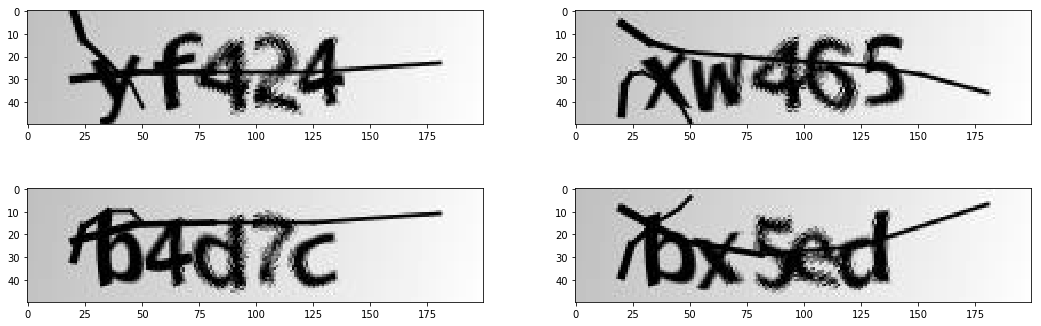

In [4]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 6))
plt.gray()
g = ax1.imshow(x[0][:, :, 0])
g = ax2.imshow(x[1][:, :, 0])
g = ax3.imshow(x[2][:, :, 0])
g = ax4.imshow(x[3][:, :, 0])


# Data Augmentation

This step is made to generate a new set of data samples to train the model on from the given data. Given that we have a limited dataset (~1000 samples) but a high number of labels to predict (5), we need to artificially create more data.

Because letters are not symmetrical, we must only focus on creating more data points by rotating, zooming and shifting the original data.



In [5]:
datagen = ImageDataGenerator(
        rotation_range = 5,       # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.05,        # Randomly zoom image 
        width_shift_range=0.05,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.05,  # randomly shift images vertically (fraction of total height)
)

# Model Design

Here we create the model with shallow linear layers and the last deep layers: a stack of 5 non-sequential layers. 

In [6]:
def model(input_shape, output_shape):
    
    x = Input(shape=input_shape)
    hidden = Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
    hidden = Conv2D(32, kernel_size=(3, 3), activation='relu')(hidden)
    hidden = MaxPool2D((2, 2))(hidden)

    hidden = BatchNormalization()(hidden)
    hidden = Conv2D(64, kernel_size=(3, 3), activation='relu')(hidden)
    hidden = Conv2D(64, kernel_size=(3, 3), activation='relu')(hidden)
    hidden = MaxPool2D((2, 2))(hidden)

    hidden = BatchNormalization()(hidden)
    hidden = Flatten()(hidden)
    
    # Make 5 branches from it, each responsible of predicting one letter
    outs = []
    for _ in range(5):
        branch = Dense(128, activation='relu')(hidden)
        drop = Dropout(0.2)(branch)
        res = Dense(len(symbols), activation='sigmoid')(drop)
        outs.append(res)
    
    return Model(inputs=x, outputs=outs)

model = model((x.shape[1], x.shape[2], 1), len(symbols))

In [7]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

model.compile(loss=categorical_crossentropy, optimizer=optimizer, 
              metrics=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy',
                       'categorical_crossentropy', 'categorical_crossentropy'])

# Training 

In [8]:
for i in range(30):
    print("Epoch: ", i)
    # Reset images
    x_gen = x.copy()
    # For each image
    for i in range(len(x)):
        # Randomly
        if(np.random.randint(10) > 7):
            # Apply random transform
            x_gen[i] = datagen.random_transform(x[i])
    # Train for an epoch
    history = model.fit(x_gen, [y[:, 0], y[:, 1], y[:, 2], y[:, 3], y[:, 4]],
                        epochs = 1,
                        batch_size = 16,
                        verbose = 0,
                        validation_split=0.2)

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29


# Model Evaluation

In this part, we will look at ways to evaluate the model we trained. We will firstly build a metric for perfect match between the model prediction and the sample's label. We will also consider a more lenient metric for partial correctness: model prediction with a least half the letter/digits correctly predicted.

In [9]:
import difflib

# Define function to predict captcha
def predict(filepath):
    label = filepath[-9:-4]
    # Load image 
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    # Normalize
    img = img / 255.
    # Predict CAPTCHA
    prediction = model.predict(img[np.newaxis, :, :, np.newaxis])
    ans = np.reshape(np.array(prediction), (5, 36))
    
    letter_index = []
    # For each letter in the CAPTCHA
    for a in ans:
        # Find which symbol the model predicted
        letter_index.append(np.argmax(a))

    # Construct the predicted CAPTCHA
    capt = ''
    for l in letter_index:
        capt += symbols[l]
        
    # Find prediction match
    match = difflib.SequenceMatcher(None, label, capt,).ratio()

    return capt, match

In [10]:
def eval():
    n_samples = int(len(os.listdir(path)) * split)
    partial_accuracy = 0
    total_accuracy = 0
    # For each image in the test directory
    for i, pic in enumerate(os.listdir(path)):
        if(i > n_samples):
            # Predict
            prediction, acc = predict(os.path.join('../input/samples/samples', pic))
            # Gather model metrics
            if(acc == 1):
                total_accuracy += 1
            
            if(acc > 0.5):
                partial_accuracy += acc
            print(pic[:-4], prediction)
            
    # Average the accuracy
    return total_accuracy / int(len(os.listdir(path)) * (1 - split)), partial_accuracy / int(len(os.listdir(path)) * (1 - split))

In [11]:
print(eval())

87nym 37nyn
x38fn x38fn
dnmd8 dbn6d
7bb7b 7bp7p
e5n66 e5n66
3ny45 3ny45
pn7pn pn7pn
fpw76 fpw27
p6mn8 p6my8
865wm 865wm
p8ngx p8ngx
c43b4 c43b4
785n4 785n4
2cgyx 2cgyg
y2ye8 y2ye8
y5dpp y5dpp
368y5 378y5
478nx 478nx
ygenn ygenn
p5nce p5nce
bd3b7 bd3b7
befbd befbd
5nnff 5mnff
4743p 4743b
nfcwy nfcwy
cd6p4 cd6p4
56ncx 36ncx
3nw7w 3my2w
mnef5 nnef3
xp24p xp24p
nmw46 nmw46
243mm 243mm
b84xc p84xc
3p67n 3p67m
nxx25 nxx25
pdw38 pdw38
pg2yx pg2yx
bny4w bny4w
fdpgd fdpgd
82fx2 82f22
gc2wd dc2yd
ddcne ddcne
8bbw8 8b5y8
xxbm5 x7bn3
5wddw 5wddw
6ydyp 6ydyp
w4cdc w4cdc
d8dce d2cce
44xe8 44xe8
b5nmm b5mmm
y7mnm y7nmn
3n7mx 3n7nx
8ne4g 8ne4g
2wx73 2wx23
nn6w6 nn6w3
84w7x 84w7x
dnne7 dnne7
dd5w5 dd5y5
yge7c yge7c
w8f36 wbf26
68x48 68x48
n2c85 n2c67
pm47f pmy7f
3ndxd 3ndxd
cg5dd cd5dd
bn5mw bn5mw
n7ebx n7ebx
yyg5g yyd5g
pyf65 myf65
5ng6e 5ng6e
mfc35 mff25
2g7nm 2g7wm
yw8y5 yw8y5
x4f7g x4f7g
n7dyb n7dyb
5n732 5n722
6n6gg 6n6pg
x7547 77547
d3c7y d3c7y
xemyg xenyg
nfndw nfndw
7e2y7 7e2y7
6bdn5 6bdb5
6end

Overall, our model finds about half of the testing samples correctly. And about 30% of the total samples not correctly classified are at least partially correct.